# **Connect to GDRIVE**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls '/content/drive/My Drive/skripsiku/data/split_data'

test  train  val


# **Import Library**

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tqdm import tqdm
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

# **Inisiasi Direktori (Split Data)**

In [6]:
train_dir = '/content/drive/My Drive/skripsiku/data/split_data/train'
val_dir = '/content/drive/My Drive/skripsiku/data/split_data/val'
test_dir = '/content/drive/My Drive/skripsiku/data/split_data/test'

# **Data Preparation**

In [32]:
# Augmentasi untuk data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [33]:
# Validasi dan test hanya dilakukan rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

# Generator untuk validasi
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Generator untuk test
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)


Found 560 images belonging to 4 classes.
Found 160 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


# **Show Data Augmentasi**

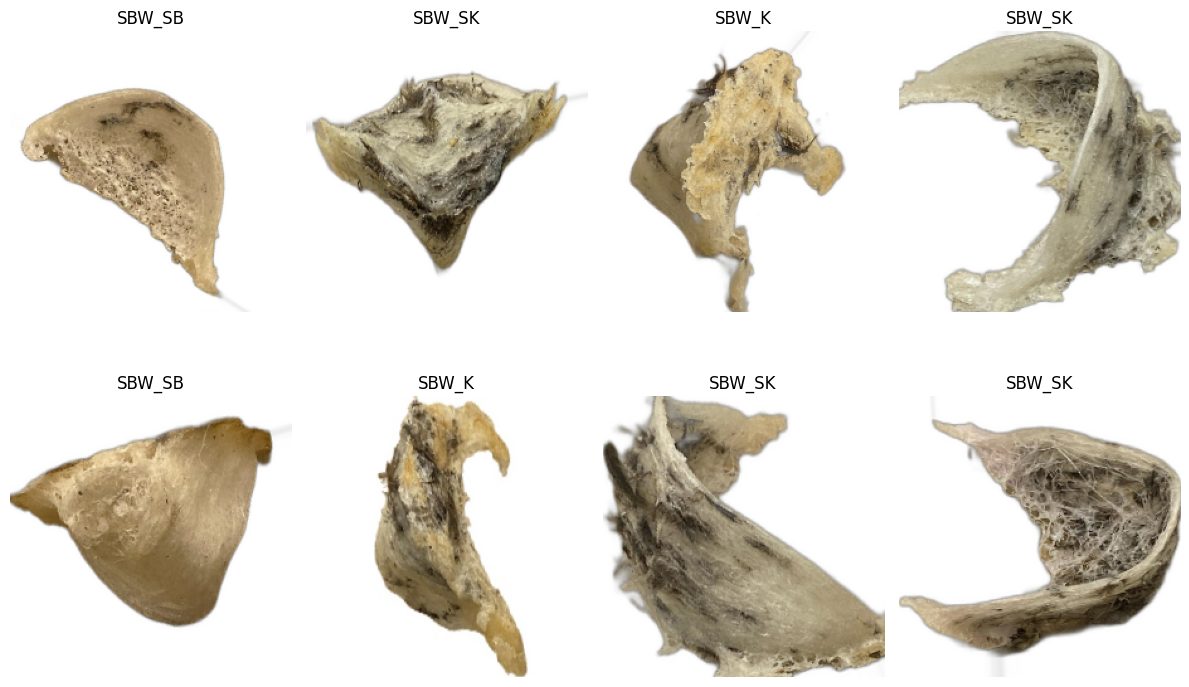

In [34]:
# Ambil satu batch dari train_generator
images, labels = next(train_generator)  # ambil batch pertama

# Ambil mapping kelas dari generator
class_indices = train_generator.class_indices
categories = list(class_indices.keys())  # urutannya sama dengan label output

# Tampilkan 8 gambar pertama
plt.figure(figsize=(12, 8))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    label_idx = np.argmax(labels[i])
    plt.title(categories[label_idx])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [35]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [36]:
vgg16_base.trainable = True
for layer in vgg16_base.layers[:6]:
    layer.trainable = False

In [37]:
for i, layer in enumerate(vgg16_base.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

Layer 0: input_layer_3, Trainable: False
Layer 1: block1_conv1, Trainable: False
Layer 2: block1_conv2, Trainable: False
Layer 3: block1_pool, Trainable: False
Layer 4: block2_conv1, Trainable: False
Layer 5: block2_conv2, Trainable: False
Layer 6: block2_pool, Trainable: True
Layer 7: block3_conv1, Trainable: True
Layer 8: block3_conv2, Trainable: True
Layer 9: block3_conv3, Trainable: True
Layer 10: block3_pool, Trainable: True
Layer 11: block4_conv1, Trainable: True
Layer 12: block4_conv2, Trainable: True
Layer 13: block4_conv3, Trainable: True
Layer 14: block4_pool, Trainable: True
Layer 15: block5_conv1, Trainable: True
Layer 16: block5_conv2, Trainable: True
Layer 17: block5_conv3, Trainable: True
Layer 18: block5_pool, Trainable: True


In [38]:
model = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

In [39]:
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        focal_loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=1))
    return loss

In [45]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=categorical_focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

In [46]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

In [47]:
class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            acc = logs.get('accuracy')
            val_acc = logs.get('val_accuracy')
            if acc is not None and val_acc is not None:
                if acc > 0.90 and val_acc > 0.90:
                    print(f"\nEpoch {epoch+1}: accuracy ({acc:.2%}) dan val_accuracy ({val_acc:.2%}) > 90% — Training dihentikan.")
                    self.model.stop_training = True

In [48]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[reduce_lr, CustomEarlyStopping()]
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.2520 - loss: 1.3863 - val_accuracy: 0.2500 - val_loss: 1.3863 - learning_rate: 1.0000e-04
Epoch 2/100


KeyboardInterrupt: 

In [ ]:
# Visualisasi akurasi dan loss selama pelatihan
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluasi model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

# Prediksi gambar uji
pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
filenames = test_generator.filenames  # ambil nama file

# Contoh prediksi
print("\nContoh prediksi:")
for i in range(len(filenames)):
    filename = filenames[i].split("/")[-1]  # ambil nama file saja, tanpa path folder
    true_label = class_labels[true_classes[i]]
    pred_label = class_labels[pred_classes[i]]
    print(f"{0+len(filenames)}. {filename}: Aktual = {true_label}, Prediksi = {pred_label}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.6998 - loss: 0.0660

Test Accuracy: 0.74
Test Loss: 0.07
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 880ms/step

Contoh prediksi:
B_0007.jpg: Benar = SBW_B, Prediksi = SBW_SB
B_0008.jpg: Benar = SBW_B, Prediksi = SBW_B
B_0009.jpg: Benar = SBW_B, Prediksi = SBW_B
B_0023.jpg: Benar = SBW_B, Prediksi = SBW_B
B_0024.jpg: Benar = SBW_B, Prediksi = SBW_K
B_0027.jpg: Benar = SBW_B, Prediksi = SBW_SB
B_0029.jpg: Benar = SBW_B, Prediksi = SBW_B
B_0036.jpg: Benar = SBW_B, Prediksi = SBW_B
B_0056.jpg: Benar = SBW_B, Prediksi = SBW_B
B_0058.jpg: Benar = SBW_B, Prediksi = SBW_B
B_0060.jpg: Benar = SBW_B, Prediksi = SBW_B
B_0063.jpg: Benar = SBW_B, Prediksi = SBW_B
B_0071.jpg: Benar = SBW_B, Prediksi = SBW_SB
B_0109.jpg: Benar = SBW_B, Prediksi = SBW_SB
B_0140.jpg: Benar = SBW_B, Prediksi = SBW_B
B_0152.jpg: Benar = SBW_B, Prediksi = SBW_SB
B_0164.jpg: Benar = SBW_B, Prediksi = SBW_SB
B_0174.jpg: Benar = SBW_B, Prediksi = SBW_B
B_0189.jpg: Benar = SBW_B, Prediksi =

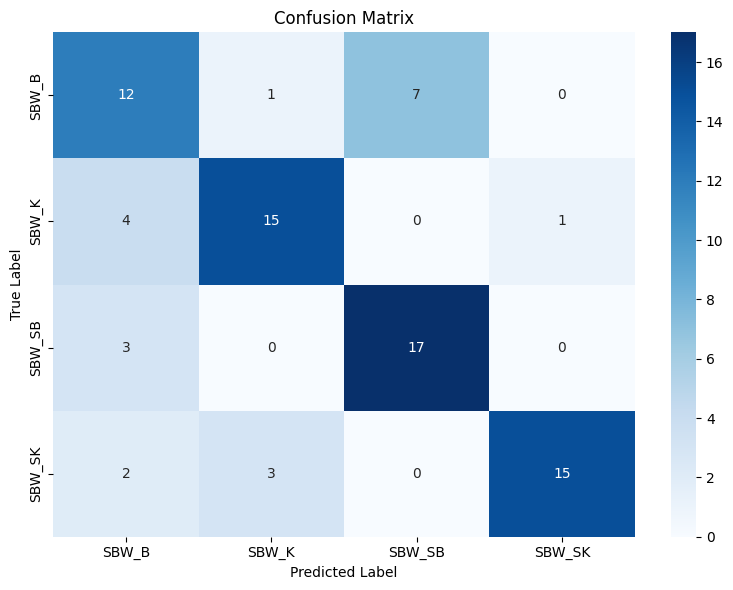


Classification Report:
              precision    recall  f1-score   support

       SBW_B       0.57      0.60      0.59        20
       SBW_K       0.79      0.75      0.77        20
      SBW_SB       0.71      0.85      0.77        20
      SBW_SK       0.94      0.75      0.83        20

    accuracy                           0.74        80
   macro avg       0.75      0.74      0.74        80
weighted avg       0.75      0.74      0.74        80



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Buat confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Tambahan: Classification report
print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))